# Modelo de predicción para los impagos de préstamos

In [4]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, norm

from sklearn.metrics import roc_curve, auc, accuracy_score # Se  importaron los metodos para hacer la grafia roc
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols 

In [5]:
df = pd.read_csv('data/Lending_club_cleaned_2.csv',
                 dtype = {'loan_status':'category', 'annual_inc':'float',
                          'verification_status':'category', 'emp_length':'category',
                          'home_ownership':'category', 'int_rate':'object',
                          'loan_amnt':'float', 'purpose':'category',
                          'term':'category', 'grade':'category'})
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float')

In [6]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


## Modelo de regresión logística

Haciamos las normalizaciones y caracterizaciones de las variables , y llevamos las a la normalidad

In [7]:
# normalizar y configurar los datos
df_log = pd.concat([(df['loan_amnt'] - df['loan_amnt'].mean())/df['loan_amnt'].std(),
                     (df['int_rate'] - df['int_rate'].mean())/df['int_rate'].std(),
                     (df['annual_inc'] - df['annual_inc'].mean())/df['annual_inc'].std(),
                     pd.get_dummies(df['home_ownership'], prefix='home', drop_first=True).astype(int),  # son variables categoricas para volverlo decodificar. 
                     pd.get_dummies(df['purpose'], prefix='purpose', drop_first=True).astype(int),      # son variables categoricas 
                     pd.get_dummies(df['grade'], prefix='grade', drop_first=True).astype(int)], axis=1) # son variables categoricas 
df_log['verification_status'] = df['verification_status'].cat.codes # tiene un orden 
df_log['emp_length'] = df['emp_length'].cat.codes                   # tiene un orden que va mejor que la otra variable 
df_log['term'] = df['term'].cat.codes
df_log['Intercept'] = 1

# ajustar el modelo de regresión logística
logit_full1 = sm.Logit(df['loan_status'].cat.codes, df_log) # aqui es para logista usa la logit 
logit_full1_res = logit_full1.fit()                         #
predict_withvs = logit_full1_res.predict(df_log)
# por que se usa cat.codes y otros , usar get_dummies 
# toca tener encuenta que los dummies es igualdad es decir no es mejor todo es igualdad 
# toca usar cat.codes tiene un orden natural eso es ordinal 

Optimization terminated successfully.
         Current function value: 0.378195
         Iterations 7


Podemos comprobar la curva ROC y el AUC del modelo:

Roc , mirar el desempeno en una clasificaicon binaria , caracteristica operativa del recpetor.
sirve para medir la medida de desempeno de clasificacion binaria. 
los ejes la tasa de verdaderos postivos, la tasa de de falso positivo, la lina de es una moneda en el aire , si los modelos estan abajo es perverso 


la cursa se construye el humbral de clasificion , 

la curva que tenga mayor area bajo la curva sera el mejor modelo

https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg

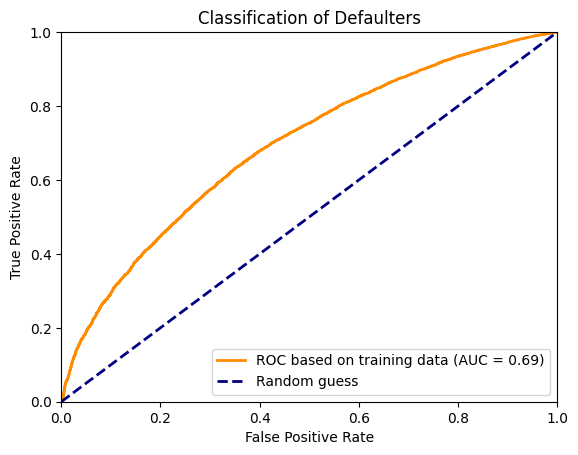

In [8]:
#A continuación trazamos la curva ROC:
roc_vs = roc_curve(df['loan_status'].cat.codes, predict_withvs) # es el modelo que creamos. de regecion logisticas
auc_vs = auc( roc_vs[0], roc_vs[1] ) # enviamos las dos columnas que nos devulve roc 

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")
# graficamos 
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess') # es la linea punteada 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

## El clasificador Naive Bayes

El clasificador que veremos a continuación se basa en un resultado muy simple pero poderoso en estadística: El teorema de Bayes. Antes de profundizar en el clasificador, necesitaremos algunas nociones muy básicas de probabilidades condicionales. Sin embargo, la idea de cómo funciona el clasificador es muy sencilla:

> Dado un cliente con ciertas características, utilizaremos el teorema de Bayes y los datos observados para estimar la probabilidad de que los morosos y los no morosos tengan las mismas características que el cliente. La mayor de estas dos probabilidades determinaría entonces cómo clasificamos al cliente.

### Probabilidad condicional y teorema de Bayes

Sean $A$ y $B$ un par de eventos. Por ejemplo, pensemos en $A$ como el suceso de que un cliente sea moroso y en $B$ como el suceso de que se hayan verificado los ingresos del cliente. La **probabilidad condicional** del suceso $A$ dado el suceso $B$ se define como la probabilidad de observar el suceso $A$ siempre que el suceso $B$ ya haya ocurrido. Numéricamente, esto significa:

$$
\text{P($A$ given $B$)} =P(A|B)= \frac{\text{P($A$ and $B$)}}{\text{P($B$)}}.
$$

Por supuesto, no hay nada especial en $A$ o $B$, así que podemos invertirlos en la identidad anterior para obtener:

$$
\text{P($B$ given $A$)} = \frac{\text{P($B$ and $A$)}}{\text{P($A$)}}.
$$

Observe que los numeradores del lado derecho de ambas ecuaciones son idénticos. Por lo tanto, podemos igualarlas y sustituir el resto de cada identidad para obtener:

$$
\begin{align}
    \text{P($A$ given $B$)}\text{P($B$)} &= \text{P($B$ given $A$)}\text{P($A$)} \\
    \\
    \Rightarrow\text{P($A$ given $B$)} &= \frac{\text{P($B$ given $A$)}\text{P($A$)}} {\text{P($B$)}}
\end{align}
$$

Este es el famoso **teorema de Bayes**, sobre el que se construye el clasificador Naive Bayes.

### Ejercicio:


#### 2.1

Utilice los datos para estimar los valores de $\text{P(moroso)}$ y $\text{P(no moroso)}$.

**Respuesta**

In [9]:
df

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4 years,MORTGAGE,8.07,2500.0,home_improvement,36 months,A
38701,Fully Paid,18000.0,Not Verified,3 years,RENT,10.28,8500.0,credit_card,36 months,C
38702,Fully Paid,100000.0,Not Verified,< 1 year,MORTGAGE,8.07,5000.0,debt_consolidation,36 months,A
38703,Fully Paid,200000.0,Not Verified,< 1 year,MORTGAGE,7.43,5000.0,other,36 months,A


In [10]:
#total=df["loan_status"].count()
df["loan_status"].value_counts('Fully Paid')


loan_status
Fully Paid     0.85945
Charged Off    0.14055
Name: proportion, dtype: float64

In [11]:
x=df["loan_status"].value_counts(normalize=True)

In [12]:
x[0]

0.8594496835034233

P(defaulter)=0.141

P(non-defaulter)=0.859

#### 2.2

Utiliza la definición de probabilidad condicional y los datos para estimar las probabilidades

$$
\text{P(ingresos verificados dado el moroso) y P(ingresos verificados dado el no moroso)}
$$


**Respuesta**

In [13]:
#df['verification_status']
len(df[(df['loan_status'] == 'Fully Paid') & (df['verification_status'] == 'Verified')])/len((df[df['loan_status'] == 'Fully Paid']))


0.3129415301367804

In [14]:
len(df[(df['loan_status'] == 'Charged Off') & (df['verification_status'] == 'Verified')])/len((df[df['loan_status'] == 'Charged Off']))

0.3634191176470588

P(income verified given defaulter)=0.363

P(income verified given non-defaulter)=0.313

### Introducción al algoritmo

### ¿Por qué el clasificador es "ingenuo"?

Necesitamos muchas muestras para poder estimar $\text{P(covariables=valores dados por defecto)}$ para todos los $\text{valores}$ posibles utilizando proporciones observadas. Para evitar este problema, el clasificador Naive Bayes asume que *todas las covariables son independientes cuando se condicionan al resultado*. Esta suposición puede no ser nunca cierta en el mundo real, por lo que el método se llama "ingenuo". Sin embargo, en la práctica no suele suponer un gran obstáculo para la herramienta y proporciona resultados bastante potentes la mayor parte del tiempo.

En nuestro caso, el supuesto implica que dentro de los morosos/no morosos, todas las covariables se distribuyen de forma independiente:

$$
\text{P(covariables=valores dado el no moroso)} = \text{P(covariable}_1\text{=valor}_1\text{ dado el no moroso)}\times\cdots\times\text{P(covariable}_p\text{=valor}_p\text{ dado el no moroso)}
$$

Aquí asumimos que hay $p$ covariables en total.

## Implementación del clasificador

### Usando `sklearn.MultinomialNB` y `sklearn.GaussianNB`

Una implementación del clasificador Naive Bayes basada en variables mixtas categóricas-continuas no está implementada en `sklearn` por defecto. Sin embargo, por los supuestos de independencia *ingenua* de nuestro clasificador, es posible utilizar las implementaciones para variables discretas (`sklearn.MultinomialNB`) y continuas (`sklearn.GaussianNB`) como sigue. Supongamos, para simplificar, que queremos estimar:
    
$$
\text{P(non-defaulter given loan\_amnt, term)}
$$


usando

$$
\begin{equation}
\begin{aligned}
\text{P(non-defaulter given loan\_amnt)} \quad \text{and} \quad \text{P(non-defaulter given term).}
\end{aligned}
\end{equation}
$$

Por el teorema de Bayes tenemos

$$
\begin{aligned}
\text{P(non-defaulter given loan\_amnt, term)} &= \frac{\text{P(term, loan\_amnt given non-defaulter)P(non-defaulter)}}{\text{P(term, loan\_amnt)}}, \\
&\approx \frac{\text{P(term given non-defaulter)P(loan\_amnt given non-defaulter)P(non-defaulter)}}{\text{P(term)P(loan\_amnt)}}, \\
&= \text{P(non-defaulter)} \frac{\text{P(term given non-defaulter)}}{\text{P(term)}} \frac{\text{P(loan\_amnt given non-defaulter)}}{\text{P(loan\_amnt)}}, \\
&= \frac{\text{P(non-defaulter given term)} \text{P(non-defaulter given loan\_amnt)}}{\text{P(non-defaulter)}}
\end{aligned}
$$



En palabras más sencillas, el supuesto de independencia ingenua nos permite calcular las probabilidades ajustando primero un modelo para las variables discretas y las continuas por separado. A continuación, multiplicamos estos valores y los dividimos por las probabilidades a priori $\text{P(no incumplidor)}$ y $\text{P(incumplidor)}$.

Como ejemplo, vamos a ajustar un clasificador de Naive Bayes utilizando las covariables `term`, `verification_status`, `loan_amnt_sqrt` y `annual_inc_log`:

In [15]:
df['annual_inc_log'] = np.log10(df['annual_inc'])
df['loan_amnt_sqrt'] = np.sqrt(df['loan_amnt'])
p_def = 0.141

In [16]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

df_nb=df.copy()

#Codificar las variables categóricas:
for var in ['loan_status', 'term','verification_status']:
    df_nb[var]=df_nb[var].cat.codes

#Ajustamos el modelo para las variables continuas
y=df_nb['loan_status']
Xcont=df_nb[['annual_inc_log','loan_amnt_sqrt']]
gnb = GaussianNB()
cont_probas=gnb.fit(Xcont, y).predict_proba(Xcont)

#Ajustamos el modelo para variables categóricas
Xcat=df_nb[['term','verification_status']]
mnb=MultinomialNB()
cat_probas=mnb.fit(Xcat, y).predict_proba(Xcat)


#multiplicar las probabilidades y dividirlas por los priores
nb_probas=np.multiply(cont_probas, cat_probas)/np.array([p_def, 1-p_def])

#añadir las probabilidades al data frame
df_nb['nb_predict_proba']=nb_probas[:,1]
df_nb['nb_predict_proba']

0        0.865864
1        0.817663
2        0.803235
3        0.877488
4        0.855876
           ...   
38700    0.896243
38701    0.821499
38702    0.895022
38703    0.915678
38704    0.833035
Name: nb_predict_proba, Length: 38705, dtype: float64

In [17]:
np.multiply(cont_probas, cat_probas)/np.array([p_def, 1-p_def])

array([[0.12962354, 0.86586428],
       [0.18536848, 0.81766342],
       [0.1965561 , 0.8032353 ],
       ...,
       [0.10510967, 0.89502233],
       [0.0845303 , 0.91567835],
       [0.16686741, 0.83303457]])

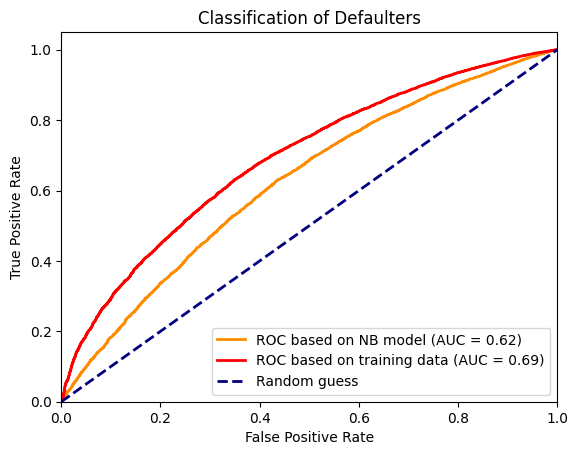

In [18]:
roc_nb= roc_curve(df_nb['loan_status'], df_nb['nb_predict_proba'])
auc_nb= auc( roc_nb[0], roc_nb[1] )

plt.figure()
line_width = 2
plt.plot(roc_nb[0], roc_nb[1], color='darkorange', lw=line_width,
         label=f"ROC based on NB model (AUC = {auc_nb:0.2f})")
plt.plot(roc_vs[0], roc_vs[1], color='red', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()